# Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shapely

import networkx as nx
import osmnx as ox
from pprint import pprint

import pickle 

In [2]:
# color palette for visualizing walking/biking discomfort
chosen_cmap = sns.color_palette("Spectral", as_cmap = True)

# Read data

In [3]:
folder = "01_outputs/"

Gb_edges = gpd.read_file(folder + "geofabrik_bike_graph_edges_w_EDSAaccidents.geojson").set_index(["u", "v", "key"], drop = True)
Gb_nodes = gpd.read_file(folder + "geofabrik_bike_graph_nodes_w_brgycode_popdensity.geojson").set_index("osmid", drop = True)
Gw_edges = gpd.read_file(folder + "geofabrik_walk_graph_edges_w_EDSAaccidents.geojson").set_index(["u", "v", "key"], drop = True)
Gw_nodes = gpd.read_file(folder + "geofabrik_walk_graph_nodes_w_brgycode_popdensity.geojson").set_index("osmid", drop = True)

In [4]:
Gb_edges.shape, Gw_edges.shape

((14878, 159), (15332, 159))

In [5]:
Gb_edges.index.is_unique, Gw_edges.index.is_unique

(True, True)

In [6]:
assumed_crs = "4326"

city_adm3_pcode = "PH137401000"

city_initial_digits = "PH137401"

In [7]:
brgy_geo = gpd.read_file("01_outputs/CCHAIN_FILTERED_brgy_geography.geojson")

brgy_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    27 non-null     object        
 1   adm4_pcode              27 non-null     object        
 2   date                    27 non-null     datetime64[ms]
 3   freq                    27 non-null     object        
 4   brgy_total_area_x       27 non-null     float64       
 5   brgy_distance_to_coast  27 non-null     float64       
 6   brgy_is_coastal         27 non-null     bool          
 7   adm1_en                 27 non-null     object        
 8   adm1_pcode              27 non-null     object        
 9   adm2_en                 27 non-null     object        
 10  adm2_pcode              27 non-null     object        
 11  adm3_en                 27 non-null     object        
 12  adm3_pcode              27 non-null     obje

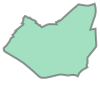

In [8]:
brgy_geo_for_city = brgy_geo.loc[brgy_geo["adm4_pcode"].str.startswith(city_initial_digits)].copy(deep = True)

city_geo = brgy_geo_for_city.union_all()
city_geo

# Estimate node probability distribution (i.e., demand)

## popdensity

In [9]:
Gb_nodes.columns

Index(['visible', 'changeset', 'x', 'y', 'version', 'timestamp', 'tags',
       'HAS_TAG', 'TAG_access', 'TAG_barrier', 'TAG_crossing',
       'TAG_crossing:markings', 'TAG_crossing:signals', 'TAG_highway',
       'TAG_supervised', 'TAG_mapillary', 'TAG_survey:date',
       'TAG_crossing:island', 'TAG_tactile_paving', 'TAG_source:position',
       'TAG_traffic_signals', 'TAG_barrier:personnel', 'TAG_source:geometry',
       'TAG_button_operated', 'TAG_kerb', 'TAG_wheelchair', 'TAG_crossing_ref',
       'TAG_addr:housenumber', 'TAG_addr:street', 'TAG_gate:type',
       'TAG_traffic_calming', 'TAG_alt_name', 'TAG_bus', 'TAG_check_date',
       'TAG_name', 'TAG_public_transport', 'TAG_source', 'TAG_door',
       'TAG_entrance', 'TAG_level', 'TAG_locked', 'TAG_amenity', 'TAG_note',
       'TAG_maxheight', 'TAG_parking', 'TAG_traffic_signals:vibration',
       'TAG_access:conditional', 'TAG_addr:city', 'TAG_addr:province',
       'TAG_opening_hours', 'TAG_image', 'TAG_noexit',
       'TAG_m

<Axes: >

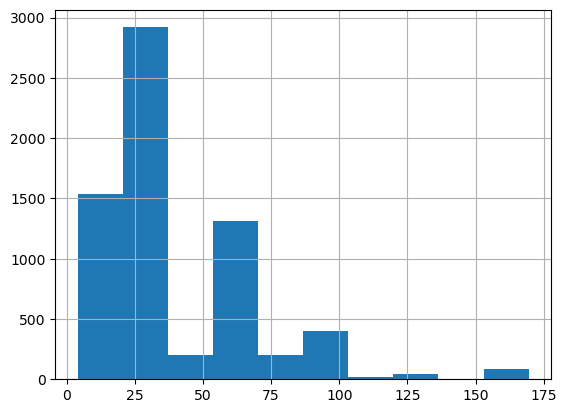

In [10]:
Gb_nodes['META_population_density_2020'].hist()

In [11]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

In [12]:
Gb_popdensity_zscore = pd.Series(
    std_scaler.fit_transform(Gb_nodes[["META_population_density_2020"]]).flatten(),
    index = Gb_nodes.index
)

Gb_popdensity_zscore

osmid
321734921     -0.222668
26365570      -0.222668
8594662788    -0.222668
6320023164    -0.222668
25583974       1.878972
                 ...   
11997820023    0.847488
813134352     -0.498915
12101126573   -0.498915
12101126572   -0.498915
6773491495    -0.130718
Length: 6712, dtype: float64

<Axes: >

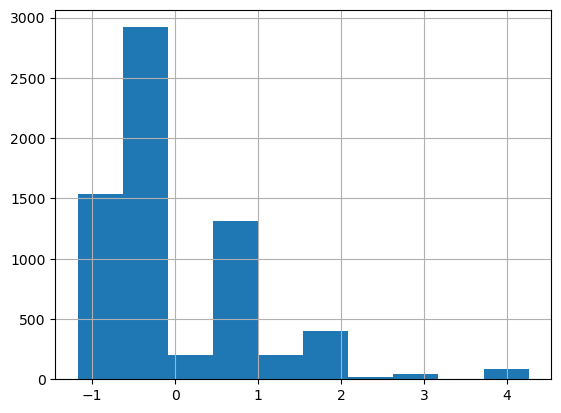

In [13]:
Gb_popdensity_zscore.hist()

## get official osmnx graphs

In [14]:
download_official_osmnx_graphs = False

if download_official_osmnx_graphs:

    # get the official osmnx graphs in order to be able to use ox.basic_stats() on them

    Gb_official = ox.graph_from_place("Mandaluyong City, Philippines", network_type="bike")
    Gw_official = ox.graph_from_place("Mandaluyong City, Philippines", network_type="walk")

    ox.save_graphml(Gb_official, "05_outputs/official_osmnx_graph_bike.graphml")
    ox.save_graphml(Gw_official, "05_outputs/official_osmnx_graph_walk.graphml")

In [15]:
# Note: we may want to use the undirected version of the graph because we want to get circuity average.
# if so, then use ox.convert.to_undirected() on these graphs.

Gb_official = ox.load_graphml("05_outputs/official_osmnx_graph_bike.graphml")
Gb_official = ox.project_graph(Gb_official, to_crs = "EPSG:25391")
Gw_official = ox.load_graphml("05_outputs/official_osmnx_graph_walk.graphml")
Gw_official = ox.project_graph(Gw_official, to_crs = "EPSG:25391")

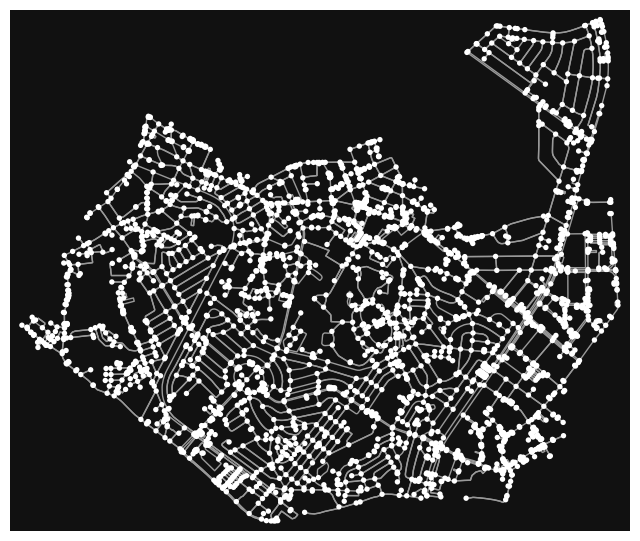

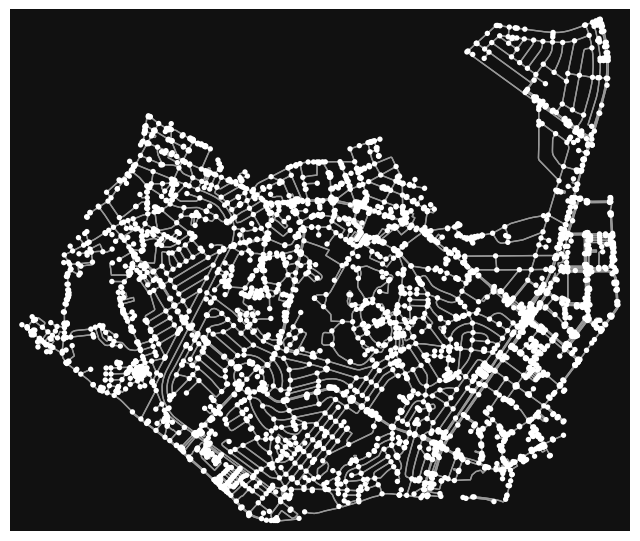

In [16]:
ox.plot_graph(Gb_official)
ox.plot_graph(Gw_official)
plt.show()

In [17]:
Gb_official_nodes, Gb_official_edges = ox.graph_to_gdfs(Gb_official)
Gw_official_nodes, Gw_official_edges = ox.graph_to_gdfs(Gw_official)

In [18]:
ox.basic_stats(Gb_official)

{'n': 2804,
 'm': 5954,
 'k_avg': 4.24679029957204,
 'edge_length_total': 332647.635,
 'edge_length_avg': 55.86960614712798,
 'streets_per_node_avg': np.float64(2.5509985734664764),
 'streets_per_node_counts': {0: 0, 1: 768, 2: 26, 3: 1715, 4: 287, 5: 8},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.2738944365192582,
  2: 0.009272467902995721,
  3: 0.6116262482168331,
  4: 0.10235378031383738,
  5: 0.0028530670470756064},
 'intersection_count': np.int64(2036),
 'street_length_total': 200444.099,
 'street_segment_count': 3539,
 'street_length_avg': 56.63862644814919,
 'circuity_avg': np.float64(1.0506728487802024),
 'self_loop_proportion': 0.0011302627860977678}

## intersection density

### draft on test point

In [19]:
test_position = 400

In [20]:
example_circle_center = Gb_official_nodes.iloc[test_position].at["geometry"]

example_circle = example_circle_center.buffer(250)

type(example_circle_center), type(example_circle)

(shapely.geometry.point.Point, shapely.geometry.polygon.Polygon)

In [21]:
example_subgraph = ox.truncate.truncate_graph_polygon(Gb_official, example_circle,
                                                      retain_all = True, # ok if disconnected
                                                      truncate_by_edge = False # don't allow nodes that are neighbors of nodes in the polygon
                                                      )
nodes_example_subgraph, edges_example_subgraph = ox.graph_to_gdfs(example_subgraph)

In [22]:
# FOR GRAPHING

import pyproj

from shapely.ops import transform

epsg4326 = pyproj.CRS('EPSG:4326')
epsg25391 = pyproj.CRS('EPSG:25391')

crs_projection = pyproj.Transformer.from_crs(epsg4326, epsg25391, always_xy=True).transform
crs_projection_reversed = pyproj.Transformer.from_crs(epsg25391, epsg4326, always_xy=True).transform

city_geo_transformed = transform(crs_projection, city_geo)

In [23]:
# # # for comparison to what the plot would look like with the actual graph we're going to use

# fig, ax = plt.subplots()

# # city
# brgy_geo_for_city.plot(aspect = 1, ax = ax, color = "black")

# Gb_edges.plot(aspect = 1, ax = ax, color = "white")

# plt.title("City map")
# plt.show()

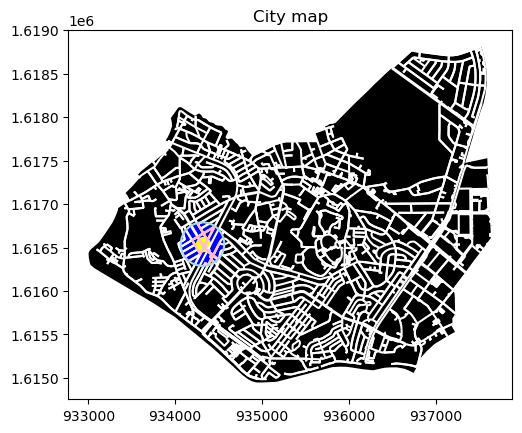

In [24]:
fig, ax = plt.subplots()

# city
gpd.GeoSeries(city_geo_transformed).plot(aspect = 1, ax = ax, color = "black")

Gb_official_edges.plot(aspect = 1, ax = ax, color = "white")

edges_example_subgraph.plot(aspect = 1, ax = ax, color = "pink")

# thing being tested

gpd.GeoSeries(example_circle).plot(aspect = 1, ax = ax, color = "blue")
gpd.GeoSeries(shapely.boundary(example_circle)).plot(aspect = 1, ax = ax, color = "lightblue")

Gb_official_nodes.iloc[[test_position]].plot(aspect = 1, ax = ax, color = "yellow", markersize = 100)

plt.title("City map")
plt.show()

In [25]:
ox.stats.intersection_count(example_subgraph, min_streets = 3)

np.int64(35)

### function for intersection density

In [26]:
def intersection_density_around_point(point, source_graph, radius_meters = 250):
    """point: Shapely Point object. radius_meters: integer. Output is intersection density = number of intersections / area in square meters."""

    point_transformed = transform(crs_projection, point)

    circle = point_transformed.buffer(radius_meters)

    subgraph = ox.truncate.truncate_graph_polygon(source_graph, circle,
                                                        retain_all = True, # ok if disconnected
                                                        truncate_by_edge = False # don't allow nodes that are only neighbors of nodes in the polygon
                                                        )
    area_sqm = np.pi * (radius_meters ** 2)
    intersection_density = ox.stats.intersection_count(subgraph, min_streets = 3) / area_sqm
    return intersection_density

In [27]:
to_apply_b = lambda s: intersection_density_around_point(s["geometry"], source_graph = Gb_official)
to_apply_w = lambda s: intersection_density_around_point(s["geometry"], source_graph = Gw_official)

In [28]:
type(transform(crs_projection, example_circle_center))

shapely.geometry.point.Point

In [29]:
get_intersection_density = False

if get_intersection_density:

    Gb_intersection_density = Gb_nodes.apply(to_apply_b, axis = 1)
    Gb_intersection_density.name = "intersection_density_per_sqm"

    Gw_intersection_density = Gw_nodes.apply(to_apply_w, axis = 1)
    Gw_intersection_density.name = "intersection_density_per_sqm"

    Gb_intersection_density.to_csv("05_outputs/intersection_density_around_nodes_bike.csv", index = True)
    Gw_intersection_density.to_csv("05_outputs/intersection_density_around_nodes_walk.csv", index = True)

In [30]:
# read from file

Gb_intersection_density = pd.read_csv("05_outputs/intersection_density_around_nodes_bike.csv").set_index("osmid", drop = True)["intersection_density_per_sqm"]
Gw_intersection_density = pd.read_csv("05_outputs/intersection_density_around_nodes_walk.csv").set_index("osmid", drop = True)["intersection_density_per_sqm"]

In [31]:
Gb_intersection_density

osmid
321734921      0.000158
26365570       0.000143
8594662788     0.000143
6320023164     0.000158
25583974       0.000173
                 ...   
11997820023    0.000097
813134352      0.000219
12101126573    0.000357
12101126572    0.000341
6773491495     0.000173
Name: intersection_density_per_sqm, Length: 6712, dtype: float64

<Axes: >

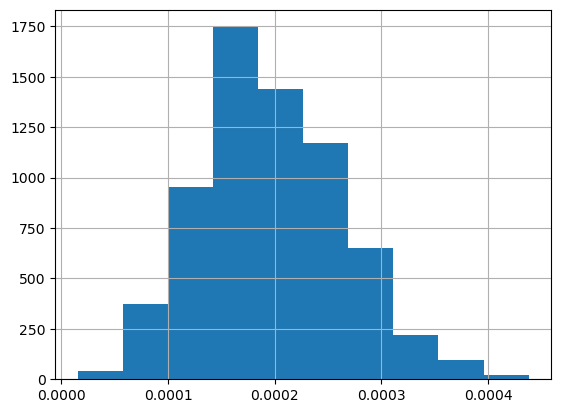

In [32]:
Gb_intersection_density.hist()

## land use entropy

In [33]:
landuse = gpd.read_file("06_outputs/combined_landuse_indicators.geojson")
landuse

,LAND_USE_TYPE,geom_type,geometry
0,retail,Polygon,"POLYGON ((121.04369 14.5739, 121.04343 14.5737..."
1,residential,Polygon,"POLYGON ((121.05062 14.57666, 121.05127 14.577..."
2,office,Polygon,"POLYGON ((121.05963 14.58699, 121.05807 14.586..."
3,residential,Polygon,"POLYGON ((121.02313 14.58023, 121.02367 14.579..."
4,retail,Polygon,"POLYGON ((121.05865 14.5846, 121.05865 14.5856..."
...,...,...,...
2812,residential,Polygon,"POLYGON ((121.04172 14.57465, 121.04256 14.573..."
2813,institutional,Polygon,"POLYGON ((121.02094 14.58557, 121.02115 14.585..."
2814,office,Polygon,"POLYGON ((121.02119 14.58472, 121.02121 14.584..."
2815,office,Polygon,"POLYGON ((121.05566 14.57703, 121.05571 14.577..."


In [34]:
landuse["geom_type"].value_counts()

geom_type
Polygon         2057
Point            750
MultiPolygon      10
Name: count, dtype: int64

In [35]:
landuse_transformed = landuse.to_crs("EPSG:25391")

landuse_transformed[["geometry"]]

,geometry
0,"POLYGON ((935895.869 1615703.618, 935867.393 1..."
1,"POLYGON ((936638.533 1616022.864, 936706.859 1..."
2,"POLYGON ((937591.105 1617185.684, 937423.049 1..."
3,"POLYGON ((933663.029 1616365.611, 933721.784 1..."
4,"POLYGON ((937490.394 1616918.267, 937488.404 1..."
...,...
2812,"POLYGON ((935681.523 1615782.385, 935773.166 1..."
2813,"POLYGON ((933415.616 1616953.313, 933438.461 1..."
2814,"POLYGON ((933444.182 1616859.642, 933446.373 1..."
2815,"POLYGON ((937181.968 1616073.622, 937187.044 1..."


### draft

In [36]:
test_position2 = 40

In [37]:
point = Gb_nodes.iloc[test_position2]["geometry"]

radius_meters = 250

# start

point_transformed = transform(crs_projection, point)

circle = point_transformed.buffer(radius_meters)

circle_untransformed = transform(crs_projection_reversed, circle)

subset_places = landuse.loc[landuse.intersects(circle_untransformed)]

In [38]:
subset_places

,LAND_USE_TYPE,geom_type,geometry
444,institutional,Point,POINT (121.0385 14.57617)
445,institutional,Point,POINT (121.03856 14.57618)
459,entertainment,Point,POINT (121.0383 14.57611)
473,institutional,Point,POINT (121.04068 14.57643)
633,entertainment,Point,POINT (121.04085 14.57612)
784,institutional,Point,POINT (121.03869 14.5772)
795,entertainment,Point,POINT (121.03873 14.57624)
812,institutional,Point,POINT (121.04041 14.57613)
813,institutional,Point,POINT (121.04012 14.57656)
814,entertainment,Point,POINT (121.04072 14.57618)


### function for land use entropy

from https://shapely.readthedocs.io/en/stable/reference/shapely.get_type_id.html

get_type_id(geometry, **kwargs)
Returns the type ID of a geometry.

None (missing) is -1

POINT is 0

LINESTRING is 1

LINEARRING is 2

POLYGON is 3

MULTIPOINT is 4

MULTILINESTRING is 5

MULTIPOLYGON is 6

GEOMETRYCOLLECTION is 7

In [39]:
shapely.get_type_id(example_circle_center)

np.int32(0)

In [40]:
shapely.area(example_circle_center) # point has no area

np.float64(0.0)

In [41]:
def area_from_geometry(geom):
    # geom: Shapely geometry. Note it should have already been converted to EPSG:25391 so that area is in meters squared.
    typeid = shapely.get_type_id(geom)
    # things with no area
    if typeid in (0, 1, 2, 4, 5):
        area = 170 # this is the approximate mean building area found in the buildings dataset
    # things with area
    elif typeid in (3, 6):
        area = shapely.area(geom)
    else:
        area = 0
    
    return area

In [42]:
area_from_geometry(circle) # this is correct, in meters, based on what the radius is in meters.

np.float64(196034.28065913962)

In [43]:
landuse_transformed

,LAND_USE_TYPE,geom_type,geometry
0,retail,Polygon,"POLYGON ((935895.869 1615703.618, 935867.393 1..."
1,residential,Polygon,"POLYGON ((936638.533 1616022.864, 936706.859 1..."
2,office,Polygon,"POLYGON ((937591.105 1617185.684, 937423.049 1..."
3,residential,Polygon,"POLYGON ((933663.029 1616365.611, 933721.784 1..."
4,retail,Polygon,"POLYGON ((937490.394 1616918.267, 937488.404 1..."
...,...,...,...
2812,residential,Polygon,"POLYGON ((935681.523 1615782.385, 935773.166 1..."
2813,institutional,Polygon,"POLYGON ((933415.616 1616953.313, 933438.461 1..."
2814,office,Polygon,"POLYGON ((933444.182 1616859.642, 933446.373 1..."
2815,office,Polygon,"POLYGON ((937181.968 1616073.622, 937187.044 1..."


In [44]:
subset_places = landuse_transformed.loc[landuse_transformed.intersects(circle)].copy(deep = True)

if subset_places.shape[0] <= 1:
    # if there are no land use objects found, or only one is found, assume an entropy of zero (one land use dominates the area).
    land_use_entropy = 0
else:
    subset_places["geometry"] = subset_places["geometry"].clip(circle)
    subset_places["area"] = subset_places["geometry"].apply(area_from_geometry)
    area_occupied_per_land_use_type = subset_places[["LAND_USE_TYPE", "area"]].groupby("LAND_USE_TYPE")["area"].sum()
    # # # AS A TEST
    # area_occupied_per_land_use_type = pd.Series({"residential": 1, "retail": 0, "entertainment": 0, "office": 0, "institutional": 0})
    perc_occupied_per_land_use_type = area_occupied_per_land_use_type / (area_occupied_per_land_use_type.sum())
    land_use_entropy = -(perc_occupied_per_land_use_type * np.log(perc_occupied_per_land_use_type)).sum() / np.log(5)

In [45]:
perc_occupied_per_land_use_type

LAND_USE_TYPE
entertainment    0.128818
institutional    0.608323
office           0.159280
residential      0.103420
retail           0.000159
Name: area, dtype: float64

In [46]:
land_use_entropy

np.float64(0.6803725540983003)

In [47]:
def land_use_entropy_around_point(point, landuse_transformed, radius_meters = 250):
    """point: Shapely Point object. radius_meters: integer. Output is intersection density = number of intersections / area in square meters."""

    point_transformed = transform(crs_projection, point)

    circle = point_transformed.buffer(radius_meters)

    subset_places = landuse_transformed.loc[landuse_transformed.intersects(circle)].copy(deep = True)

    if subset_places.shape[0] <= 1:
        # if there are no land use objects found, or only one is found, assume an entropy of zero (one land use dominates the area).
        land_use_entropy = 0
    else:
        subset_places["geometry"] = subset_places["geometry"].clip(circle)
        subset_places["area"] = subset_places["geometry"].apply(area_from_geometry)
        area_occupied_per_land_use_type = subset_places[["LAND_USE_TYPE", "area"]].groupby("LAND_USE_TYPE")["area"].sum()
        perc_occupied_per_land_use_type = area_occupied_per_land_use_type / (area_occupied_per_land_use_type.sum())
        land_use_entropy = -(perc_occupied_per_land_use_type * np.log(perc_occupied_per_land_use_type)).sum() / np.log(5)

    return land_use_entropy

In [48]:
to_apply_b = lambda s: land_use_entropy_around_point(s["geometry"], landuse_transformed)
to_apply_w = lambda s: land_use_entropy_around_point(s["geometry"], landuse_transformed)

In [49]:
get_land_use_entropy = False

if get_land_use_entropy:

    Gb_land_use_entropy = Gb_nodes.apply(to_apply_b, axis = 1)
    Gb_land_use_entropy.name = "land_use_entropy"

    Gw_land_use_entropy = Gw_nodes.apply(to_apply_w, axis = 1)
    Gw_land_use_entropy.name = "land_use_entropy"

    Gb_land_use_entropy.to_csv("05_outputs/land_use_entropy_around_nodes_bike.csv", index = True)
    Gw_land_use_entropy.to_csv("05_outputs/land_use_entropy_around_nodes_walk.csv", index = True)

In [50]:
# read from file

Gb_land_use_entropy = pd.read_csv("05_outputs/land_use_entropy_around_nodes_bike.csv").set_index("osmid", drop = True)["land_use_entropy"]
Gw_land_use_entropy = pd.read_csv("05_outputs/land_use_entropy_around_nodes_walk.csv").set_index("osmid", drop = True)["land_use_entropy"]

In [51]:
Gb_land_use_entropy

osmid
321734921      0.872254
26365570       0.893496
8594662788     0.873744
6320023164     0.845268
25583974       0.372005
                 ...   
11997820023    0.552046
813134352      0.569403
12101126573    0.723621
12101126572    0.731832
6773491495     0.967245
Name: land_use_entropy, Length: 6712, dtype: float64

<Axes: >

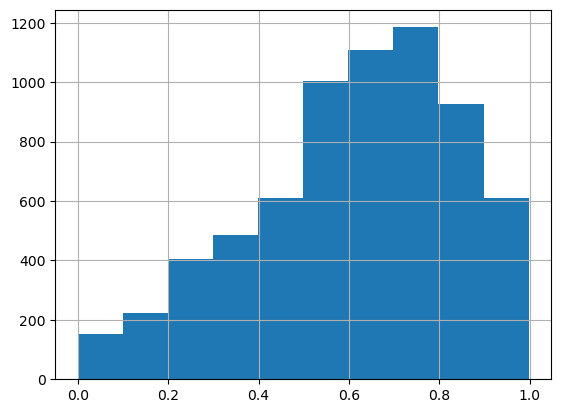

In [52]:
Gb_land_use_entropy.hist()

## PROB. ESTIMATE

In [53]:
# first, take z-scores as frank et al did

<Axes: >

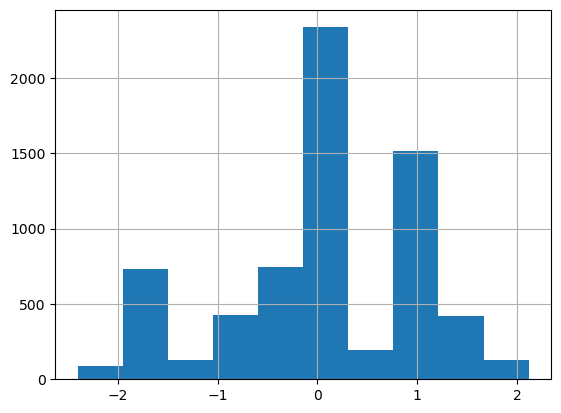

In [54]:
# important: since population density seems really right-skewed for an area that doesn't even seem like it should have a significantly higher population density, i decided to take the log of the population density. This also has the effect of making the data more normally distributed, or at least symmetric.

Gb_popdensity_zscore = pd.Series(
    std_scaler.fit_transform(np.log(Gb_nodes[["META_population_density_2020"]])).flatten(),
    index = Gb_nodes.index
)

Gw_popdensity_zscore = pd.Series(
    std_scaler.fit_transform(np.log(Gw_nodes[["META_population_density_2020"]])).flatten(),
    index = Gw_nodes.index
)

Gb_popdensity_zscore.hist()

In [55]:
Gb_intersection_density

osmid
321734921      0.000158
26365570       0.000143
8594662788     0.000143
6320023164     0.000158
25583974       0.000173
                 ...   
11997820023    0.000097
813134352      0.000219
12101126573    0.000357
12101126572    0.000341
6773491495     0.000173
Name: intersection_density_per_sqm, Length: 6712, dtype: float64

<Axes: >

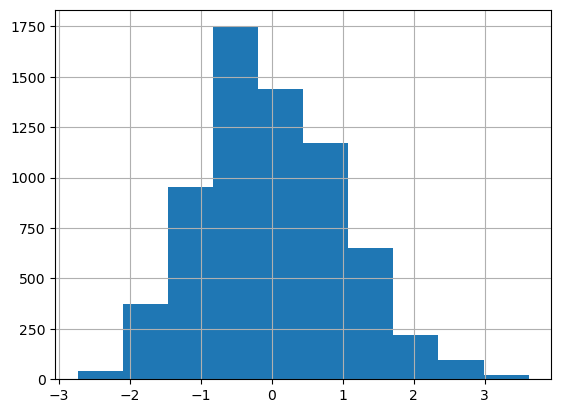

In [56]:
Gb_intersection_density_zscore = pd.Series(
    std_scaler.fit_transform(pd.DataFrame(Gb_intersection_density)).flatten(),
    index = Gb_nodes.index
)

Gw_intersection_density_zscore = pd.Series(
    std_scaler.fit_transform(pd.DataFrame(Gw_intersection_density)).flatten(),
    index = Gw_nodes.index
)

Gb_intersection_density_zscore.hist()

<Axes: >

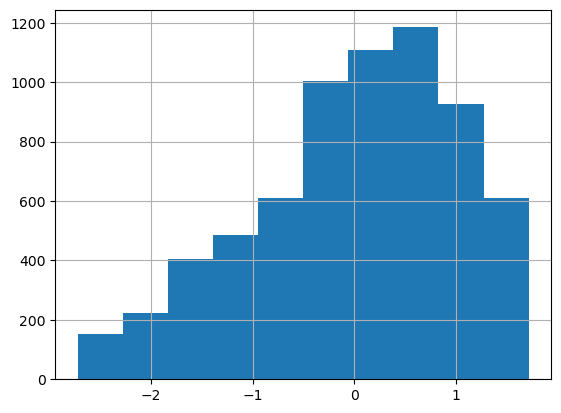

In [57]:
Gb_land_use_entropy_zscore = pd.Series(
    std_scaler.fit_transform(pd.DataFrame(Gb_land_use_entropy)).flatten(),
    index = Gb_nodes.index
)

Gw_land_use_entropy_zscore = pd.Series(
    std_scaler.fit_transform(pd.DataFrame(Gw_land_use_entropy)).flatten(),
    index = Gw_nodes.index
)

Gb_land_use_entropy_zscore.hist()

In [58]:
# then add them together using his weights (1 for all, except for intersection density, which has weight 2)

Gb_demand_est = 2 * Gb_intersection_density_zscore + Gb_land_use_entropy_zscore + Gb_popdensity_zscore
Gw_demand_est = 2 * Gw_intersection_density_zscore + Gw_land_use_entropy_zscore + Gw_popdensity_zscore

<Axes: >

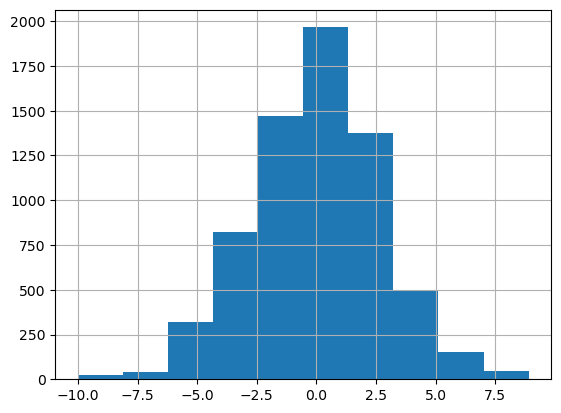

In [59]:
Gb_demand_est.hist()

<Axes: >

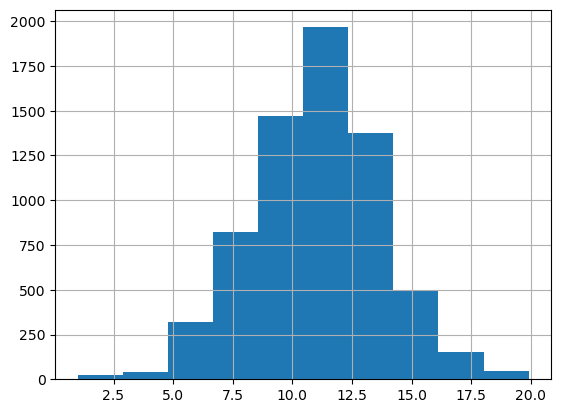

In [60]:
# shift so that the minimum value is 1, then divide to produce "probabilities"

Gb_demand_shifted = (Gb_demand_est + 1 - Gb_demand_est.min())
Gw_demand_shifted = (Gw_demand_est + 1 - Gw_demand_est.min())

Gb_demand_shifted.hist()

<Axes: >

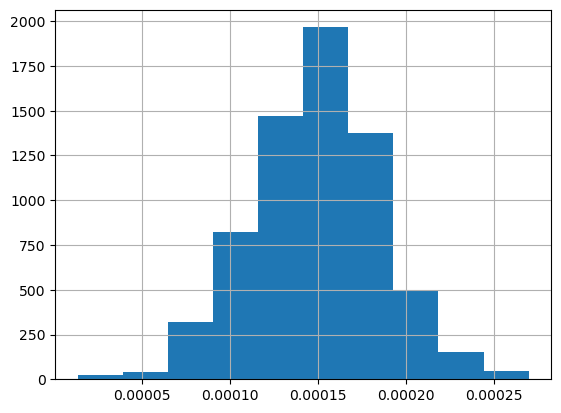

In [61]:
Gb_prob = Gb_demand_shifted / Gb_demand_shifted.sum()
Gw_prob = Gw_demand_shifted / Gw_demand_shifted.sum()

Gb_prob.hist()

In [62]:
Gb_prob.sum(), Gw_prob.sum() # should be 1

(np.float64(1.0), np.float64(0.9999999999999999))

In [63]:
Gb_prob.max(), 1 / Gb_nodes.shape[0] # compare these, should be similar in order of magnitude

(np.float64(0.0002695493966887181), 0.00014898688915375446)

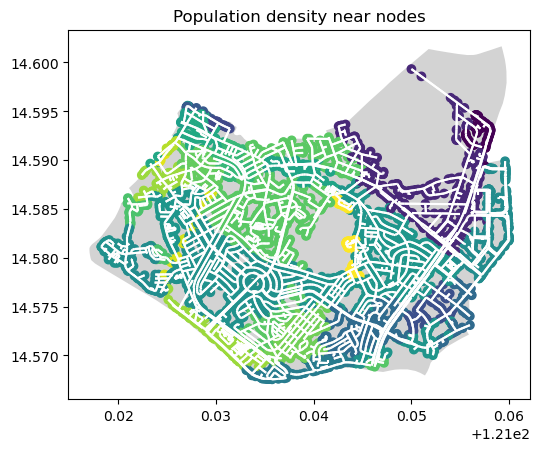

In [64]:
fig, ax = plt.subplots()

# city
gpd.GeoSeries(city_geo).plot(aspect = 1, ax = ax, color = "lightgray")

Gb_edges.plot(aspect = 1, ax = ax, color = "white")

# thing being tested

Gb_nodes.plot(Gb_popdensity_zscore, aspect = 1, ax = ax)

plt.title("Population density near nodes")
plt.show()

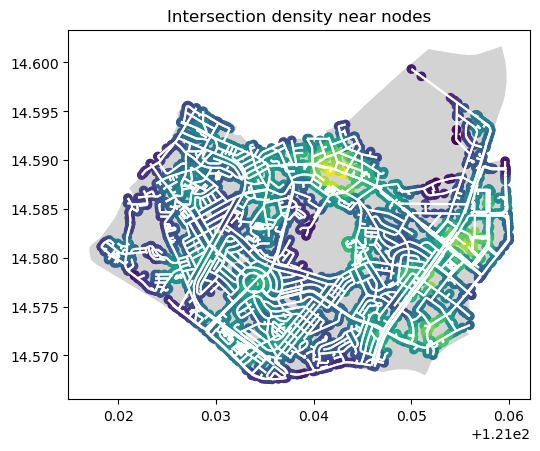

In [65]:
fig, ax = plt.subplots()

# city
gpd.GeoSeries(city_geo).plot(aspect = 1, ax = ax, color = "lightgray")

Gb_edges.plot(aspect = 1, ax = ax, color = "white")

# thing being tested

Gb_nodes.plot(Gb_intersection_density_zscore, aspect = 1, ax = ax)

plt.title("Intersection density near nodes")
plt.show()

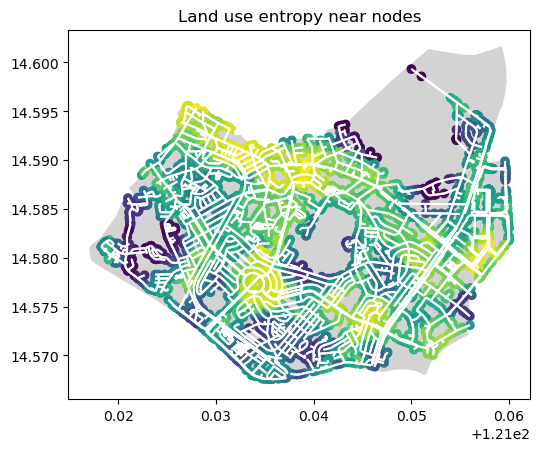

In [66]:
fig, ax = plt.subplots()

# city
gpd.GeoSeries(city_geo).plot(aspect = 1, ax = ax, color = "lightgray")

Gb_edges.plot(aspect = 1, ax = ax, color = "white")

# thing being tested

Gb_nodes.plot(Gb_land_use_entropy_zscore, aspect = 1, ax = ax)

plt.title("Land use entropy near nodes")
plt.show()

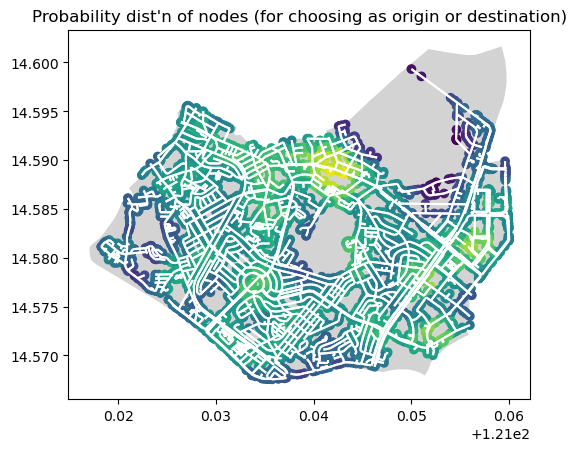

In [67]:
fig, ax = plt.subplots()

# city
gpd.GeoSeries(city_geo).plot(aspect = 1, ax = ax, color = "lightgray")

Gb_edges.plot(aspect = 1, ax = ax, color = "white")

# thing being tested

Gb_nodes.plot(Gb_prob, aspect = 1, ax = ax)

plt.title("Probability dist'n of nodes (for choosing as origin or destination)")
plt.show()

## Export

In [68]:
demand_b = pd.DataFrame(
    {
        "population_density": Gb_nodes["META_population_density_2020"],
        "population_density_log": np.log(Gb_nodes["META_population_density_2020"]),
        "population_density_zscore": Gb_popdensity_zscore,
        "intersection_density": Gb_intersection_density,
        "intersection_density_zscore": Gb_intersection_density_zscore,
        "land_use_entropy": Gb_land_use_entropy,
        "land_use_entropy_zscore": Gb_land_use_entropy_zscore,
        "probability": Gb_prob
    }
)

demand_b.head()

,population_density,population_density_log,population_density_zscore,intersection_density,intersection_density_zscore,land_use_entropy,land_use_entropy_zscore,probability
osmid,,,,,,,,
321734921,33.012115,3.496875,0.137546,0.000158,-0.588223,0.872254,1.155065,0.000151
26365570,33.012115,3.496875,0.137546,0.000143,-0.817709,0.893496,1.249372,0.000146
8594662788,33.012115,3.496875,0.137546,0.000143,-0.817709,0.873744,1.161678,0.000144
6320023164,33.012115,3.496875,0.137546,0.000158,-0.588223,0.845268,1.035253,0.000149
25583974,96.976092,4.574464,1.441233,0.000173,-0.358737,0.372005,-1.065880,0.000144


In [69]:
demand_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6712 entries, 321734921 to 6773491495
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   population_density           6712 non-null   float64
 1   population_density_log       6712 non-null   float64
 2   population_density_zscore    6712 non-null   float64
 3   intersection_density         6712 non-null   float64
 4   intersection_density_zscore  6712 non-null   float64
 5   land_use_entropy             6712 non-null   float64
 6   land_use_entropy_zscore      6712 non-null   float64
 7   probability                  6712 non-null   float64
dtypes: float64(8)
memory usage: 471.9 KB


In [70]:
demand_b.to_csv("05_outputs/demand_bike.csv", index = True)

In [71]:
demand_b = pd.read_csv("05_outputs/demand_bike.csv").set_index("osmid")

demand_b.head()

,population_density,population_density_log,population_density_zscore,intersection_density,intersection_density_zscore,land_use_entropy,land_use_entropy_zscore,probability
osmid,,,,,,,,
321734921,33.012115,3.496875,0.137546,0.000158,-0.588223,0.872254,1.155065,0.000151
26365570,33.012115,3.496875,0.137546,0.000143,-0.817709,0.893496,1.249372,0.000146
8594662788,33.012115,3.496875,0.137546,0.000143,-0.817709,0.873744,1.161678,0.000144
6320023164,33.012115,3.496875,0.137546,0.000158,-0.588223,0.845268,1.035253,0.000149
25583974,96.976092,4.574464,1.441233,0.000173,-0.358737,0.372005,-1.065880,0.000144


In [72]:
demand_w = pd.DataFrame(
    {
        "population_density": Gw_nodes["META_population_density_2020"],
        "population_density_log": np.log(Gw_nodes["META_population_density_2020"]),
        "population_density_zscore": Gw_popdensity_zscore,
        "intersection_density": Gw_intersection_density,
        "intersection_density_zscore": Gw_intersection_density_zscore,
        "land_use_entropy": Gw_land_use_entropy,
        "land_use_entropy_zscore": Gw_land_use_entropy_zscore,
        "probability": Gw_prob
    }
)

demand_w.head()

,population_density,population_density_log,population_density_zscore,intersection_density,intersection_density_zscore,land_use_entropy,land_use_entropy_zscore,probability
osmid,,,,,,,,
321734921,33.012115,3.496875,0.196258,0.000204,-0.591815,0.872254,1.177827,0.000147
26365570,33.012115,3.496875,0.196258,0.000178,-0.781036,0.893496,1.270674,0.000142
8594662788,33.012115,3.496875,0.196258,0.000183,-0.743191,0.873744,1.184337,0.000142
6320023164,33.012115,3.496875,0.196258,0.000204,-0.591815,0.845268,1.059869,0.000145
88776956,28.938799,3.365183,0.045862,0.000357,0.543510,0.594574,-0.035908,0.000161


In [73]:
demand_w.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6957 entries, 321734921 to 6773491495
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   population_density           6957 non-null   float64
 1   population_density_log       6957 non-null   float64
 2   population_density_zscore    6957 non-null   float64
 3   intersection_density         6957 non-null   float64
 4   intersection_density_zscore  6957 non-null   float64
 5   land_use_entropy             6957 non-null   float64
 6   land_use_entropy_zscore      6957 non-null   float64
 7   probability                  6957 non-null   float64
dtypes: float64(8)
memory usage: 489.2 KB


In [74]:
demand_w.to_csv("05_outputs/demand_walk.csv", index = True)

In [75]:
demand_w = pd.read_csv("05_outputs/demand_walk.csv").set_index("osmid")

demand_w.head()

,population_density,population_density_log,population_density_zscore,intersection_density,intersection_density_zscore,land_use_entropy,land_use_entropy_zscore,probability
osmid,,,,,,,,
321734921,33.012115,3.496875,0.196258,0.000204,-0.591815,0.872254,1.177827,0.000147
26365570,33.012115,3.496875,0.196258,0.000178,-0.781036,0.893496,1.270674,0.000142
8594662788,33.012115,3.496875,0.196258,0.000183,-0.743191,0.873744,1.184337,0.000142
6320023164,33.012115,3.496875,0.196258,0.000204,-0.591815,0.845268,1.059869,0.000145
88776956,28.938799,3.365183,0.045862,0.000357,0.543510,0.594574,-0.035908,0.000161


# Read components and score data

In [76]:
folder = "04_outputs/"

Gb_discomfort_components = pd.read_csv(folder + "bike_discomfort_components.csv").set_index(["u", "v", "key"], drop = True)
Gw_discomfort_components = pd.read_csv(folder + "walk_discomfort_components.csv").set_index(["u", "v", "key"], drop = True)

In [77]:
Gb_discomfort_components.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14878 entries, (np.int64(321734921), np.int64(26365570), np.int64(0)) to (np.int64(6773491495), np.int64(6375475926), np.int64(0))
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   score_weighted_by_main                14878 non-null  float64
 1   score_weighted_by_sub                 14878 non-null  float64
 2   SU_bicycle                            14878 non-null  float64
 3   SU_CYCLEWAY_CLASS                     14878 non-null  float64
 4   SU_CYCLEWAY_LANE_TYPE                 14878 non-null  float64
 5   SU_foot                               14878 non-null  float64
 6   SU_highway                            14878 non-null  float64
 7   SU_ALLEY                              14878 non-null  float64
 8   SU_width                              14878 non-null  float64
 9   SU_lit                                14878 

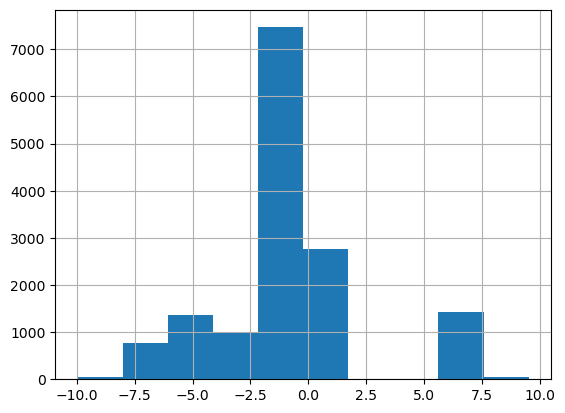

In [78]:
Gb_discomfort_components["score_weighted_by_main"].hist()
plt.show()

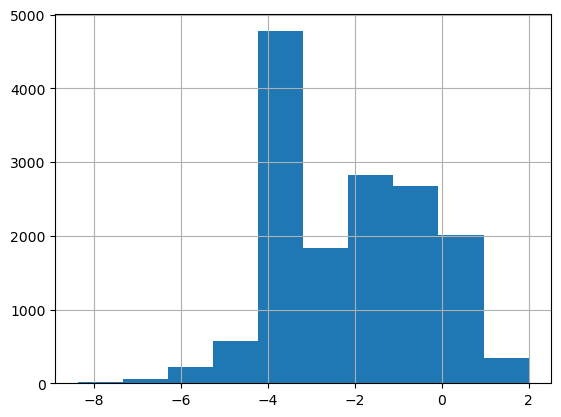

In [79]:
Gw_discomfort_components["score_weighted_by_main"].hist()
plt.show()

## Scale scores

To produce coefficients to be multiplied by edge length.

In [80]:
from sklearn.preprocessing import MinMaxScaler

In [81]:
chosen_maximum_coef = 3

coef_scaler = MinMaxScaler(feature_range = (1, chosen_maximum_coef))

b_discomfort_coefs = pd.Series(
    coef_scaler.fit_transform(Gb_discomfort_components[["score_weighted_by_main"]]).flatten(),
    index = Gb_discomfort_components.index
)

w_discomfort_coefs = pd.Series(
    coef_scaler.fit_transform(Gw_discomfort_components[["score_weighted_by_main"]]).flatten(),
    index = Gw_discomfort_components.index
)

In [82]:
b_discomfort_totals = b_discomfort_coefs * Gb_edges["length"]

w_discomfort_totals = w_discomfort_coefs * Gw_edges["length"]

In [83]:
# CONCAT WITH FULL SET OF EDGES so it can be used in optimization
Gb_edges["discomfort_total"] = b_discomfort_totals
Gw_edges["discomfort_total"] = w_discomfort_totals

In [84]:
b_discomfort_coefs

u            v            key
321734921    26365570     0      1.508946
             8594662788   0      1.868855
             6320023164   0      1.508946
26365570     321734921    0      1.508946
8594662788   5429550720   0      1.868855
                                   ...   
12101126573  12101126574  0      2.640090
12101126572  12101126567  0      2.640090
             12101126573  0      2.640090
6773491495   248009368    0      1.303283
             6375475926   0      1.303283
Length: 14878, dtype: float64

<Axes: >

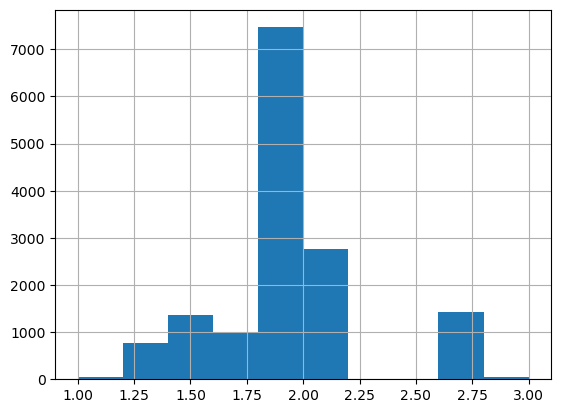

In [85]:
b_discomfort_coefs.hist()

<Axes: >

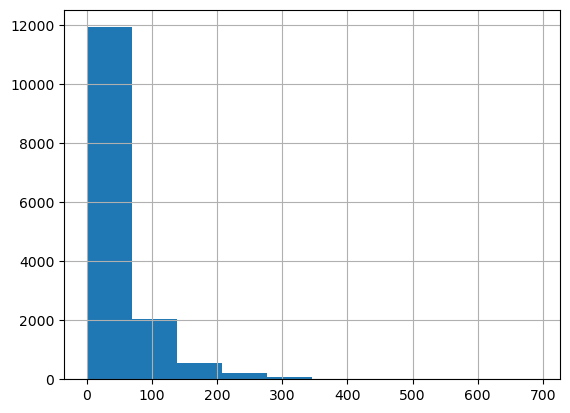

In [86]:
b_discomfort_totals.hist()

## Construct actual graph to use (from geofabrik)

NOTE: this section should come after the section on scaling discomfort scores, since Gb_nodes and Gw_edges should contain the "discomfort_total" column.

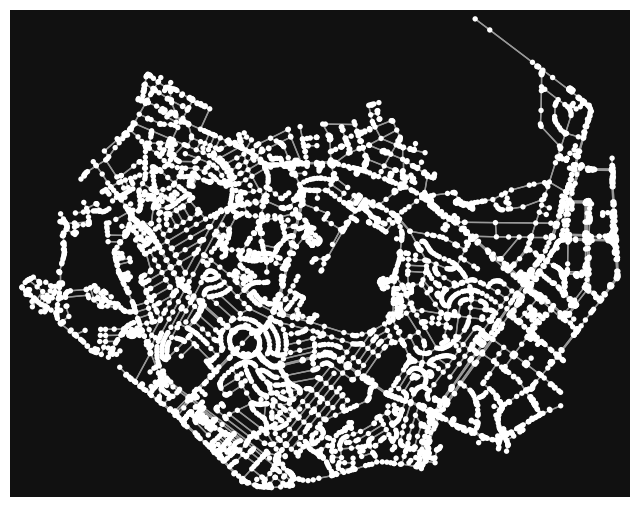

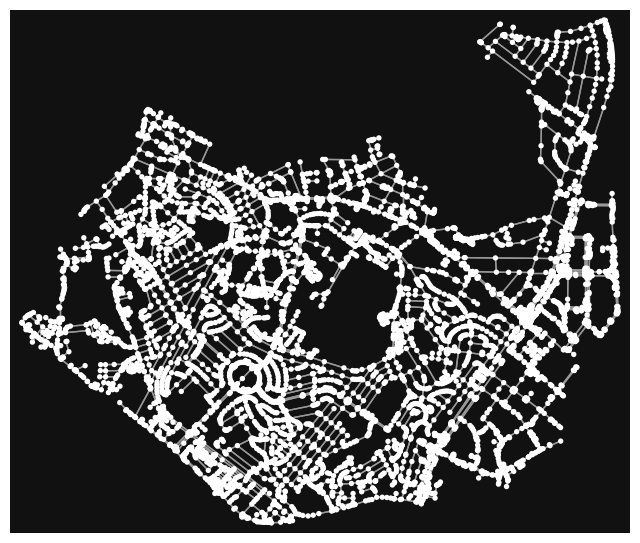

In [87]:
Gb = ox.graph_from_gdfs(Gb_nodes, Gb_edges)
Gw = ox.graph_from_gdfs(Gw_nodes, Gw_edges)

ox.plot_graph(Gb)
ox.plot_graph(Gw)
plt.show()

# Select relevant nodes

In [88]:
Gb_nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6712 entries, 321734921 to 6773491495
Data columns (total 93 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   visible                        6712 non-null   bool          
 1   changeset                      6712 non-null   int32         
 2   x                              6712 non-null   float64       
 3   y                              6712 non-null   float64       
 4   version                        6712 non-null   int32         
 5   timestamp                      6712 non-null   int32         
 6   tags                           1215 non-null   object        
 7   HAS_TAG                        6712 non-null   object        
 8   TAG_access                     440 non-null    object        
 9   TAG_barrier                    477 non-null    object        
 10  TAG_crossing                   430 non-null    object        
 11  

In [89]:
for col in Gb_nodes.columns:
    if col.startswith("TAG"):
        print("\n----------")
        print(Gb_nodes[col].value_counts(ascending = False, dropna = False))


----------
TAG_access
None           6272
private         258
destination      87
permissive       60
no               22
customers         8
delivery          3
yes               2
Name: count, dtype: int64

----------
TAG_barrier
None                 6235
gate                  359
lift_gate              65
kerb                   16
bollard                11
swing_gate              9
entrance                8
chain                   3
barricade               3
height_restrictor       2
rope                    1
Name: count, dtype: int64

----------
TAG_crossing
None               6282
uncontrolled        186
marked              120
unmarked             77
traffic_signals      26
informal             12
zebra                 9
Name: count, dtype: int64

----------
TAG_crossing:markings
None              6466
zebra              155
no                  75
lines                6
zebra:bicolour       4
surface              3
zebra:double         2
ladder               1
Name: count, dtype

## filter conditions

In [90]:
def mask_exclude_nodes(nodes_gdf):

    exclude_notnull = [
        f"TAG_{s}" for s in
        ("crossing", "crossing:markings", "crossing:signals", "crossing:island", "traffic_signals", "traffic_signals:sound", "kerb", "crossing_ref", "traffic_calming", "traffic_calming:direction", "parking", "traffic_signals:vibration", "access:conditional")
    ]

    mask = (
        (nodes_gdf[exclude_notnull].notnull().sum(axis = 1) > 0)
        | nodes_gdf["TAG_access"].isin(["private", "no", "customers", "delivery"])
        | nodes_gdf["TAG_amenity"].isin(["parking_entrance", "parking"])
        | nodes_gdf["TAG_highway"].isin(["crossing", "traffic_signals", "milestone", "stop", "give_way", "motor_junction", "elevator", "turning_circle"])
    )

    return mask

In [91]:
Gb_nodes.shape, Gw_nodes.shape

((6712, 93), (6957, 94))

In [92]:
### deprecated: sample nodes from entire dataset

n_sample = 100

Gb_nodes_f = Gb_nodes.loc[~mask_exclude_nodes(Gb_nodes)].sample(n_sample, replace = False, random_state = 42)
Gw_nodes_f = Gw_nodes.loc[~mask_exclude_nodes(Gw_nodes)].sample(n_sample, replace = False, random_state = 42)

Gb_nodes_f.shape, Gw_nodes_f.shape

((100, 93), (100, 94))

In [93]:
### deprecated
### sample nodes from each barangay then put the samples together

# n_sample_brgy = 3

# b_list = []
# w_list = []

# for index, brgy_row in brgy_geo.iterrows():

#     brgy_code = brgy_row["adm4_pcode"]
#     geo = brgy_row["geometry"]

#     Gb_nodes_f_brgy = Gb_nodes.loc[
#         (~mask_exclude_nodes(Gb_nodes))
#         & Gb_nodes.covered_by(geo)
#     ].sample(n_sample_brgy, replace = False, random_state = 0)

#     b_list.append(Gb_nodes_f_brgy)

#     Gw_nodes_f_brgy = Gw_nodes.loc[
#         (~mask_exclude_nodes(Gw_nodes))
#         & Gw_nodes.covered_by(geo)
#     ].sample(n_sample_brgy, replace = False, random_state = 0)

#     w_list.append(Gw_nodes_f_brgy)

# Gb_nodes_f = pd.concat(
#     objs = b_list,
#     axis = 0,
#     verify_integrity=True
# )

# Gw_nodes_f = pd.concat(
#     objs = w_list,
#     axis = 0,
#     verify_integrity=True
# )

# Gb_nodes_f.shape, Gw_nodes_f.shape

## check sampled nodes

In [94]:
Gb_edges["length"].isna().sum()

np.int64(0)

In [95]:
Gw_edges["length"].isna().sum()

np.int64(0)

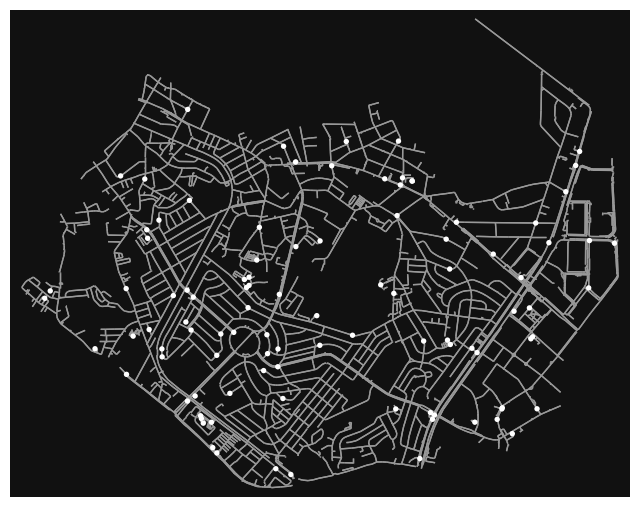

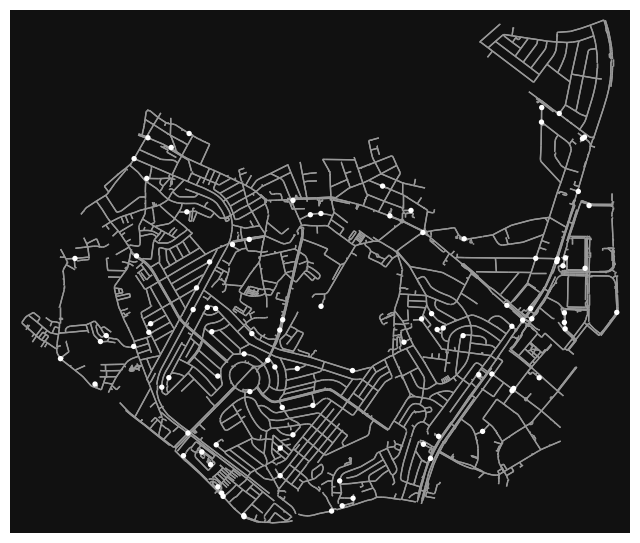

In [96]:
b_check_sample_nodes = ox.graph_from_gdfs(Gb_nodes_f, Gb_edges)
w_check_sample_nodes = ox.graph_from_gdfs(Gw_nodes_f, Gw_edges)

ox.plot_graph(b_check_sample_nodes)
ox.plot_graph(w_check_sample_nodes)
plt.show()

## export identifiers

In [97]:
with open("05_outputs/sampled_nodes_for_curve_bike.pkl", "wb") as f:
    pickle.dump(Gb_nodes_f.index.to_list(), f)

with open("05_outputs/sampled_nodes_for_curve_walk.pkl", "wb") as f:
    pickle.dump(Gw_nodes_f.index.to_list(), f)

In [98]:
# how to load

with open('05_outputs/sampled_nodes_for_curve_bike.pkl', 'rb') as f:
    b_list_nodes_sampled = pickle.load(f)

with open('05_outputs/sampled_nodes_for_curve_walk.pkl', 'rb') as f:
    w_list_nodes_sampled = pickle.load(f)

len(b_list_nodes_sampled)

100

# Heuristic: SLD

In [99]:
Gb_edges["length"].value_counts() # openstreetmap length is in meters by default

length
1.761      32
0.848      28
6.569      26
5.005      26
3.116      26
           ..
148.906     2
8.340       2
8.484       2
30.380      2
17.688      2
Name: count, Length: 4705, dtype: int64

In [100]:
example_2_nodes = Gb_nodes_f.iloc[:2].copy(deep = True)
example_2_nodes

,visible,changeset,x,y,version,timestamp,tags,HAS_TAG,TAG_access,TAG_barrier,...,TAG_survey:name,TAG_fee,TAG_traffic_calming:direction,TAG_motor_vehicle,TAG_description,TAG_layer,CCHAIN_adm4_pcode,CCHAIN_adm4_en,META_population_density_2020,geometry
osmid,,,,,,,,,,,,,,,,,,,,,
1467807116,False,0,121.027008,14.585023,6,1583169454,None,False,None,None,...,None,None,None,None,None,None,PH137401024,Poblacion,28.776398,POINT (121.02701 14.58502)
6536470737,False,0,121.045601,14.588334,2,1654408368,None,False,None,None,...,None,None,None,None,None,None,PH137401001,Addition Hills,6.163831,POINT (121.0456 14.58833)


In [101]:
points_df = example_2_nodes.to_crs('EPSG:25391')
# this is a CRS that enables distance computations in meters for Luzon. Stated here: https://epsg.io/25391
points_df2 = points_df.shift() # We shift the dataframe by 1 to align pnt1 with pnt2
points_df.distance(points_df2)

osmid
1467807116            NaN
6536470737    2041.360498
dtype: float64

In [102]:
points_df.distance(points_df2).values[1]

np.float64(2041.360497543821)

In [103]:
# full set of nodes should be used here, not filtered
Gb_nodes_meters = Gb_nodes.to_crs('EPSG:25391')
Gw_nodes_meters = Gw_nodes.to_crs('EPSG:25391')

def SLD_meters_b(node1_osmid, node2_osmid):
    points_df = Gb_nodes_meters.loc[[node1_osmid, node2_osmid]]
    points_df2 = points_df.shift()
    elementwise_distance = points_df.distance(points_df2)
    result = elementwise_distance.values[1]
    return result

def SLD_meters_w(node1_osmid, node2_osmid):
    points_df = Gw_nodes_meters.loc[[node1_osmid, node2_osmid]]
    points_df2 = points_df.shift()
    elementwise_distance = points_df.distance(points_df2)
    result = elementwise_distance.values[1]
    return result

In [104]:
SLD_meters_b(1467807116, 6536470737), SLD_meters_w(1467807116, 6536470737)

(np.float64(2041.360497543821), np.float64(2041.360497543821))

In [ ]:
# deprecated

calculate_sld = False

if calculate_sld:

    # pre-list the distances for easy lookup
    sld_lookup_b = dict()
    for i, origin in enumerate(Gb_nodes_f.index):
        for j, destination in enumerate(Gb_nodes_f.index[i:]): # set to i, not i+1, so every node is also compared to itself
            if i == j:
                dist = 0
            else:
                dist = SLD_meters_b(origin, destination)

            sld_lookup_b[(origin, destination)] = dist
            sld_lookup_b[(destination, origin)] = dist

    sld_lookup_w = dict()
    for i, origin in enumerate(Gw_nodes_f.index):
        for j, destination in enumerate(Gw_nodes_f.index[i:]): # set to i, not i+1, so every node is also compared to itself
            if i == j:
                dist = 0
            else:
                dist = SLD_meters_w(origin, destination)

            sld_lookup_w[(origin, destination)] = dist
            sld_lookup_w[(destination, origin)] = dist

    with open('05_outputs/SLD_lookup_bike.pkl', 'wb') as f:
        pickle.dump(sld_lookup_b, f)

    with open('05_outputs/SLD_lookup_walk.pkl', 'wb') as f:
        pickle.dump(sld_lookup_w, f)

In [106]:
# how to load

with open('05_outputs/SLD_lookup_bike.pkl', 'rb') as f:
    sld_lookup_b = pickle.load(f)

with open('05_outputs/SLD_lookup_walk.pkl', 'rb') as f:
    sld_lookup_w = pickle.load(f)

In [ ]:
# ### deprecated
# # new functions which use the lookup
# # if key not found, use 0 so heuristic is admissible
# def SLD_meters_b_lookup(node1_osmid, node2_osmid):
#     result = sld_lookup_b.get(
#         (node1_osmid, node2_osmid), 
#         sld_lookup_b.get(
#             (node2_osmid, node1_osmid),
#             0
#         )
#     )
#     return result

# def SLD_meters_w_lookup(node1_osmid, node2_osmid):
#     result = sld_lookup_w.get(
#         (node1_osmid, node2_osmid), 
#         sld_lookup_w.get(
#             (node2_osmid, node1_osmid),
#             0
#         )
#     )
#     return result

## New way to get SLD lookups

In [110]:
distance_matrix_b = Gb_nodes_meters["geometry"].apply(
    lambda point: Gb_nodes_meters["geometry"].distance(point)
)
distance_matrix_b.columns = Gb_nodes_meters.index

distance_matrix_w = Gw_nodes_meters["geometry"].apply(
    lambda point: Gw_nodes_meters["geometry"].distance(point)
)
distance_matrix_w.columns = Gw_nodes_meters.index


distance_matrix_b.head()

osmid,321734921,26365570,8594662788,6320023164,25583974,1467951842,1467951818,25583984,11989063260,1467951878,...,8317572223,8317572225,1190345326,8386137644,11994955927,11997820023,813134352,12101126573,12101126572,6773491495
osmid,,,,,,,,,,,,,,,,,,,,,
321734921,0.000000,28.705089,30.337676,26.126529,2662.098212,2658.286120,2682.553191,2654.654101,2656.427111,2656.518811,...,1521.856168,1515.741150,1645.197757,1563.262820,1661.857018,1147.544413,3590.304835,3463.995582,3468.092366,1499.436936
26365570,28.705089,0.000000,39.469833,54.831535,2676.493625,2672.735617,2697.081008,2668.992963,2670.950507,2671.120128,...,1548.201762,1542.018118,1672.120195,1585.148462,1656.070528,1167.078410,3618.913795,3492.646114,3496.744435,1527.844668
8594662788,30.337676,39.469833,0.000000,42.168689,2689.908021,2686.069628,2710.297381,2682.491590,2684.174313,2684.227327,...,1537.137452,1531.180727,1659.011917,1585.516513,1690.693525,1172.158471,3591.194016,3469.233074,3473.303472,1507.308453
6320023164,26.126529,54.831535,42.168689,0.000000,2649.119029,2645.257591,2669.450956,2641.727386,2643.330900,2643.351074,...,1497.915669,1491.865010,1620.714762,1543.477502,1667.447102,1130.037292,3564.274832,3437.913983,3442.009427,1473.577806
25583974,2662.098212,2676.493625,2689.908021,2649.119029,0.000000,6.936431,25.016899,9.624486,14.860631,22.828699,...,1701.350178,1695.057102,1747.479651,1298.159840,1807.662224,1561.843354,3444.031978,2989.815837,2994.820030,2098.101496


In [111]:
distance_matrix_b.at[26365570, 321734921]

np.float64(28.70508924009393)

In [117]:
with open('05_outputs/SLD_lookup_bike.pkl', 'wb') as f:
    pickle.dump(distance_matrix_b, f)

with open('05_outputs/SLD_lookup_walk.pkl', 'wb') as f:
    pickle.dump(distance_matrix_w, f)

In [119]:
def SLD_meters_b_lookup(node1_osmid, node2_osmid, distance_matrix_b):
    return distance_matrix_b.at[node1_osmid, node2_osmid]

def SLD_meters_w_lookup(node1_osmid, node2_osmid, distance_matrix_w):
    return distance_matrix_w.at[node1_osmid, node2_osmid]

# Find shortest paths (ignore; this will now just be used to demonstrate difference between shortest paths and best paths in our presentation.)

In [113]:
Gb_nodes_f.index[0]

np.int64(1467807116)

In [114]:
# # not as optimal: this uses dijkstra to find paths
# b_shortest_by_length2 = dict()
# for origin in Gb_nodes_f.index[:1]:
#     for destination in Gb_nodes_f.index:
#         best_path = nx.shortest_path(Gb, source = origin, target = destination, weight = "length")
#         b_shortest_by_length2[(origin, destination)] = best_path

In [115]:
Gb_nodes_f.shape[0] ** 2, Gw_nodes_f.shape[0] ** 2

(10000, 10000)

In [121]:
calculate_shortest_paths_by_length = True

if calculate_shortest_paths_by_length:

    b_shortest_by_length = dict()
    counter = 0
    print("Bike")
    for origin in Gb_nodes_f.index: #[:1]:
        for destination in Gb_nodes_f.index:
            counter += 1
            print(f"Solving pair: {counter}", end = "\r")
            best_path = nx.astar_path(Gb, source = origin, target = destination, heuristic = lambda a, b: SLD_meters_b_lookup(a, b, distance_matrix_b), weight = "length")
            b_shortest_by_length[(origin, destination)] = best_path

    w_shortest_by_length = dict()
    counter = 0
    print("\nWalk")
    for origin in Gw_nodes_f.index: #[:1]:
        for destination in Gw_nodes_f.index:
            counter += 1
            print(f"Solving pair: {counter}", end = "\r")
            best_path = nx.astar_path(Gw, source = origin, target = destination, heuristic = lambda a, b: SLD_meters_w_lookup(a, b, distance_matrix_w), weight = "length")
            w_shortest_by_length[(origin, destination)] = best_path

    # save
    with open('05_outputs/shortest_paths_by_length_bike.pkl', 'wb') as f:
        pickle.dump(b_shortest_by_length, f)

    with open('05_outputs/shortest_paths_by_length_walk.pkl', 'wb') as f:
        pickle.dump(w_shortest_by_length, f)

Bike
Solving pair: 10000
Walk


In [122]:
# how to load

with open('05_outputs/shortest_paths_by_length_bike.pkl', 'rb') as f:
    b_shortest_by_length = pickle.load(f)

with open('05_outputs/shortest_paths_by_length_walk.pkl', 'rb') as f:
    w_shortest_by_length = pickle.load(f)

In [123]:
example_path_nodes = list(b_shortest_by_length.values())[10]

In [124]:
example_path_nodes_gdf = Gb_nodes.loc[Gb_nodes.index.to_series().isin(example_path_nodes)]

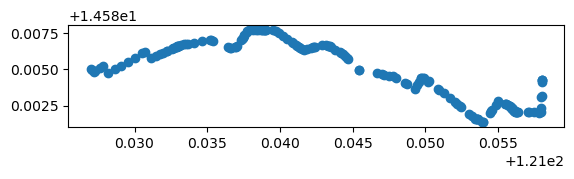

In [125]:
example_path_nodes_gdf.plot(aspect = 1)
plt.show()

# Find lowest-objective paths

This section has been moved to 07.